In [6]:
#OUTPUTS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
OUTPUTS = [0, 2, 4, 6, 8]
NB_HIDDEN_LAYERS = 1
NB_HIDDEN_NODES = [100]
NB_INPUTS = 784
NB_OUTPUTS = len(OUTPUTS)
NB_EPOCH = 5
NB_DATA = 16000
TRAINING_PATH = 'Training data/'
#TRAINING_PATH = '../training/'
TESTING_PATH = 'Testing data/'

# LEARNING RATE
L_RATE = 0.01
L_RATE_DESC = 1.0

# INITIAL WEIGHTS RANGE
WEIGHTS_LOW_BOUND = -0.5
WEIGHTS_HIGH_BOUND = 0.5

In [ ]:
from PIL import Image
import random
import numpy as np
import glob
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def loadImage(img_path, number = 0):
    pix = np.asarray(Image.open(img_path).convert('L'))
    pix = ((pix * (1 / 2550) - 0.05)).reshape(784)
    expected = []
    if OUTPUTS != []:
        for i in OUTPUTS:
            if i == number:
                expected = np.append(expected, 1)
            else:
                expected = np.append(expected, 0)
    return pix, expected

def printImage(img_path):
    plt.close()
    plt.figure()
    plt.imshow(Image.open(img_path))
    
def load_training_dataset():
    dataset = []
    expected = []
    
    filenames = []
    for o in OUTPUTS:
        for filename in glob.glob(TRAINING_PATH + str(o) + '/*.png'): 
            base = os.path.basename(filename)
            filenames.append([str(o) + '/' + base, o])
    
    random.shuffle(filenames)
    if NB_DATA != 0:
        filenames = filenames[:NB_DATA]
        
    for file in filenames:
        img, exp = loadImage(TRAINING_PATH + file[0], file[1])
        dataset.append(img)
        expected.append(exp)
        
    print('end loading dataset')
    return dataset, expected

def load_dataset(path):
    dataset = []
    filenames = []
    for filename in glob.glob(path + '/*.png'): 
        dataset.append(loadImage(filename))
        base = os.path.splitext(os.path.basename(filename))[0]
        filenames.append(base)
     
    return len(dataset), filenames


In [ ]:
def predict():
    predict_o = []
    filenames = []
    wrong = []
    correct = 0
    for number in OUTPUTS:
        for filename in glob.glob(TESTING_PATH + str(number) + '/*.png'):
            base = os.path.splitext(os.path.basename(filename))[0]
            data = loadImage(filename)
            filenames.append(base)
            
            output = forward_prop(data[0])

            val = [i for i in np.where(output == np.amax(output))]
            ans = np.around(OUTPUTS[val[0][0]]).astype(int)
            #print(val)
            if ans == number:
                correct += 1
            else:
                wrong.append([number, ans, filename])
            predict_o.append(ans)
            
    final = list()

    for i in range(len(filenames)):
        final.append({ filenames[i] : predict_o[i]})


    with open('outputs.txt', 'w') as f:
        for item in final:
            f.write("%s\n" % str(item).replace('{', '').replace('}', '').replace("'", '').replace(':', ''))
            
    print('correct : ' + str(correct) + ' (' + str((correct / len(filenames)) * 100) + ' %)')
    print('wrong : ' + str(len(filenames) - correct) + ' (' + str(((len(filenames) - correct) / len(filenames)) * 100) + ' %)')
    return wrong
    
def predict_one(data = []):
    files = []
    if data == []:
        for number in OUTPUTS:
            for filename in glob.glob(TESTING_PATH + str(number) + '/*.png'):
                f = TESTING_PATH + str(number) + '/' + os.path.basename(filename)
                files.append([number, f])
        
        input = random.choice(files)
        filename = input[1]
        correct = input[0]
    else:
        filename = data[2]
        ans = data[1]
        correct = data[0]
    img, exp = loadImage(filename)

    output = forward_prop(np.matrix(img))
    
    if data == []:
        val = [i for i in np.where(output == np.amax(output))]
        ans = np.around(OUTPUTS[val[0][0]]).astype(int)
    
    printImage(filename)
    print('program output : ' + str(ans))
    print('correct output : ' + str(correct))

In [ ]:
predict_one()

In [ ]:
wrong = predict()
for w in wrong:
    predict_one(w)
    press = input("Press Enter to continue...")
    if press == 'q':
        break

correct : 3820 (95.5 %)
wrong : 180 (4.5 %)
program output : 4
correct output : 0
Press Enter to continue...
program output : 4
correct output : 0
Press Enter to continue...
program output : 8
correct output : 0
Press Enter to continue...
program output : 8
correct output : 0
Press Enter to continue...
program output : 8
correct output : 0
Press Enter to continue...
program output : 8
correct output : 0
Press Enter to continue...
program output : 8
correct output : 0
Press Enter to continue...
program output : 2
correct output : 0
Press Enter to continue...
program output : 6
correct output : 0
Press Enter to continue...
program output : 4
correct output : 0
Press Enter to continue...
program output : 4
correct output : 0
Press Enter to continue...
program output : 8
correct output : 0
Press Enter to continue...
program output : 8
correct output : 0
Press Enter to continue...
program output : 8
correct output : 0
Press Enter to continue...
program output : 6
correct output : 0
Press En

C:\Users\Kilian\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


program output : 4
correct output : 2


In [12]:

def retrain(data_type, data_nb, nb_iter = 0, outputs = []):

    nb_outputs = 0
    nb_inputs = 0
    
    #for images
    if data_type == 'img':
        nb_inputs = 28 * 28
        
        
        
        nb_outputs = len(outputs)
        x = np.array(load_training_dataset(outputs, data_nb), dtype=np.dtype(Decimal))
        x = [[ Decimal(i) for i in j] for j in x]
    elif data_type == 'xor':
        nb_outputs = 3
        nb_inputs = 2
        x = [[1, 0, 1, 1, 1], [1, 1, 0, 1, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 1]]
    else:
        return 'Wrong datatype (should be img or xor)'


    return train_network(network, x, 1, nb_outputs, nb_iter)

In [13]:
import numpy as np
import math
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

 
def error_function(expected, outputs):
   # return (1/len(outputs)) * sum(np.square(expected - outputs))
    return sum(np.square(expected - outputs))

def forward_prop(inputs):
    global network
    vect_sigmoid = np.vectorize(sigmoid)
    
    for i in range(len(network)):
        layer = network[i]
        new_inputs = []
        
        if (inputs.shape)[0] == 1 :
            layer[0]['a'] = vect_sigmoid(np.dot(layer[1]['w'], inputs.T))
        else:
            layer[0]['a'] = vect_sigmoid(np.dot(layer[1]['w'], inputs))

        new_inputs.append(layer[0]['a'])
        inputs = new_inputs[0]
    return np.matrix(inputs)

# Update network weights with error
def update_weights(data):
    delta = []
    global L_RATE
    
    for i in range(len(network)):
        layer = network[i]
        
        if i != 0:
            delta = np.multiply((layer[3]['e'] * L_RATE).T, network[i - 1][0]['a'])
        else:
            delta = np.multiply((layer[3]['e'] * L_RATE).T, data)
        layer[1]['w'] = layer[1]['w'] + delta.T
        """
        for neuron in range(len(layer[1]['w'])):
            for b_neuron in range(len(layer[1]['w'][neuron])):
                if i != 0:
                    delta = l_rate * layer[3]['e'][neuron] * network[i - 1][0]['a'][b_neuron]
                else:
                    delta = l_rate * layer[3]['e'][neuron] * data[b_neuron]
                layer[1]['w'][neuron][b_neuron] = layer[1]['w'][neuron][b_neuron] + delta
        """
        
def backward_prop_error(expected):
    for i in reversed(range(len(network))):
        layer = network[i]
        errors = []
        
        # case where it is not the output layer
        if i != len(network)-1:
            o_errors = network[i + 1][3]['e']
            o_weights = network[i + 1][1]['w']
            
            errors = np.dot(
                np.dot(o_weights.T, o_errors),
                np.dot((layer[0]['a'].T), 1 - layer[0]['a']))
            
            layer[3]['e'] = errors
        else:
            errors = np.dot(expected.T - layer[0]['a'], np.dot((layer[0]['a']).T, (1 - layer[0]['a'])))
            layer[3]['e']  = errors
            
def update_line(hl, new_data, iter):
    hl.set_xdata(np.append(hl.get_xdata(), iter))
    hl.set_ydata(np.append(hl.get_ydata(), new_data))
    plt.draw()
    

def train_network(train, expected):
    
    global network
    global L_RATE
    global L_RATE_DESC
    print('l rate = ' + str(L_RATE))
    err_plot, = plt.plot([], [])
    plt.ylabel('error')
    axes = plt.gca()
    iter = 0
    for epoch in range(NB_EPOCH):
        error = 0
        iter = 0
        for data in train:
            new_data = data.T
            outputs = forward_prop(new_data)
            
            error += error_function(expected[iter].T, outputs)
            
            backward_prop_error(expected[iter])
            update_weights(new_data)
            
            iter += 1
            
        final_err = error / len(train)
        print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, L_RATE, final_err))
        
        L_RATE *= L_RATE_DESC
        if epoch == 0:
            axes.set_xlim([0, NB_EPOCH - 1])
            axes.set_ylim([0, float(final_err) + 0.1])
            
        update_line(err_plot, final_err, epoch)
        
        if error < 0.0001:
            print('error : ' + str(final_err))
            return network
    print('error     : ' + str(final_err))
    return network
   

def initialize_network():
    
    global network
    w = []
    
    # additionnal hidden layers
    for i in range(NB_HIDDEN_LAYERS):
        neurons = [{ 'neurons': NB_HIDDEN_NODES[i]}]
        if i == 0:
            w.append(np.random.uniform(low=WEIGHTS_LOW_BOUND, high=WEIGHTS_HIGH_BOUND, size=(NB_HIDDEN_NODES[i], NB_INPUTS)))
        else:
            w.append(np.random.uniform(low=WEIGHTS_LOW_BOUND, high=WEIGHTS_HIGH_BOUND, size=(NB_HIDDEN_NODES[i], NB_HIDDEN_NODES[i - 1])))

        network.append(neurons)
    
    # output layer
    neurons = [{ 'neurons': NB_OUTPUTS}]
    w.append(np.random.uniform(low=-0.5, high=0.5, size=(NB_OUTPUTS, NB_HIDDEN_NODES[NB_HIDDEN_LAYERS - 1])))
    network.append(neurons)
    
    for layer in network:
              
        wTmp = {'w': w[0]}
        layer.append(wTmp)
        w.pop(0)
        
        aTmp = { 'a': np.matrix(np.random.rand(layer[0]['neurons']))}
        layer.append(aTmp)
        
        eTmp = { 'e': np.matrix(np.random.rand(layer[0]['neurons']))}
        layer.append(eTmp)
        
    print('end initializing network')
    return network
  
    
# data_type => either 'img' or 'xor'
# data_nb => number of data rows (entries)
# nb_iter => number of iterations ot get to result?
# outputs => list of outputs (from 0 to 9 for img), not necessary for XOR
# nb_hidden layer => number of hidden layers, 1 by default
# nb_hidden => number of hidden neurons on each hidden layer ( 2 by default )


def train(data_type):

    global network
    global L_RATE
    expected = []
    dataset = []
    #for imagesTra
    if data_type == 'img':
        if dataset == []:
            dataset, exp = load_training_dataset()
            x = np.matrix(dataset)
            expected = np.matrix(exp)
        else:
            x = dataset
    elif data_type == 'xor':
        x = np.matrix([[1, 0, 1, 1, 1], [1, 1, 0, 1, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 1]])
    else:
        return 'Wrong datatype (should be iprintpmg or xor)'

    network = initialize_network()
    return train_network(x, expected)


end loading dataset
end initializing network
l rate = 0.01
>epoch=0, lrate=0.010, error=0.160
>epoch=1, lrate=0.010, error=0.105
>epoch=2, lrate=0.010, error=0.095
>epoch=3, lrate=0.010, error=0.090
>epoch=4, lrate=0.010, error=0.086
error     : [[0.08589425]]
correct : 3820 (95.5 %)
wrong : 180 (4.5 %)


[[0, 4, 'Testing data/0\\3203.png'],
 [0, 4, 'Testing data/0\\3210.png'],
 [0, 8, 'Testing data/0\\3311.png'],
 [0, 8, 'Testing data/0\\3469.png'],
 [0, 8, 'Testing data/0\\3578.png'],
 [0, 8, 'Testing data/0\\3592.png'],
 [0, 8, 'Testing data/0\\3609.png'],
 [0, 2, 'Testing data/0\\3653.png'],
 [0, 6, 'Testing data/0\\3654.png'],
 [0, 4, 'Testing data/0\\3679.png'],
 [0, 4, 'Testing data/0\\3681.png'],
 [0, 8, 'Testing data/0\\3697.png'],
 [0, 8, 'Testing data/0\\3828.png'],
 [0, 8, 'Testing data/0\\3919.png'],
 [0, 6, 'Testing data/0\\3930.png'],
 [0, 6, 'Testing data/0\\3950.png'],
 [0, 8, 'Testing data/0\\3956.png'],
 [2, 4, 'Testing data/2\\3203.png'],
 [2, 0, 'Testing data/2\\3224.png'],
 [2, 4, 'Testing data/2\\3226.png'],
 [2, 4, 'Testing data/2\\3230.png'],
 [2, 8, 'Testing data/2\\3239.png'],
 [2, 8, 'Testing data/2\\3249.png'],
 [2, 0, 'Testing data/2\\3272.png'],
 [2, 8, 'Testing data/2\\3276.png'],
 [2, 6, 'Testing data/2\\3314.png'],
 [2, 8, 'Testing data/2\\3324.png'],
 

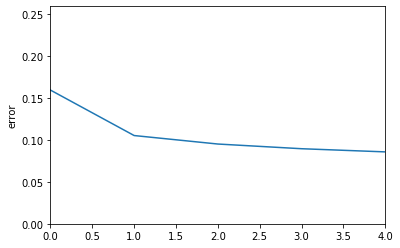

In [14]:

#test(network, [[1,0], [1,1], [0,0], [0,1]], 4)

#dataset = np.matrix(load_training_dataset([0,1, 3], 10))
#print('done')#network = retrain('img', 5000, 10, [0,1,3, 8, 9])
#test_dataset, filenames = load_testing_dataset('Testing data')
#test(network, test_dataset, 15, [0,1, 2, 3, 4, 5, 6, 7, 8, 9], filenames)
network = list()
#network = train('xor', 4, 100, [], [16, 8], 2)
network = train('img')
predict()